Things to try...

- Use word_detail info somehow to help guide to model towards better phoneme prediction
- Use BatchNorm or other techniques to get over the plateaus in the training process
- XXXX

In [1]:
!pip install wandb
!wandb online

import wandb

wandb.login()

run_config = {
        "learning_rate": 2e-5,
        "epochs": 10,
        "architecture": "WAV2VEC Finetune",
        "dataset": "TIMIT",
    }
run = wandb.init(
    # Set the project where this run will be logged
    project="badbeagle",
    # Track hyperparameters and run metadata
    config=run_config,
)

W&B online. Running your script from this directory will now sync to the cloud.


wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: dellabella-lucas. Use `wandb login --relogin` to force relogin


wandb: WARNING Tried to log to step 1 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 2 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 3 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 4 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/define-metric to log data out of order.
wandb: WARNING Tried to log to step 5 that is less than the current step 63. Steps must be monotonically increasing, so this data will be ignored. See https://wandb.me/

# Preprocess TIMIT dataset

## Download dataset to machine

In [2]:
%load_ext autoreload
%autoreload 2

import os

DATA_DIR = 'data/timit-dataset-kaggle'
DATASET_ZIP = f'{DATA_DIR}/darpa-timit-acousticphonetic-continuous-speech.zip'

# If statements save time on rerunning this cell
if not os.path.exists(DATA_DIR):
  !mkdir -p {DATA_DIR}
  !kaggle datasets download -d mfekadu/darpa-timit-acousticphonetic-continuous-speech -p {DATA_DIR}

import zipfile
if os.path.exists(DATASET_ZIP):
  with zipfile.ZipFile(DATASET_ZIP, 'r') as zip_ref:
      zip_ref.extractall(DATA_DIR)
  !rm -f {DATASET_ZIP}


## Load dataset in HF Dataset format

In [3]:
import os
import torch
import evaluate
from tqdm.auto import tqdm
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

os.environ["WANDB_DISABLED"] = "true"
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

raw_datasets = load_dataset("timit_asr", data_dir='data/timit-dataset-kaggle', trust_remote_code=True)

In [4]:
raw_datasets['train'].features

{'file': Value(dtype='string', id=None),
 'audio': Audio(sampling_rate=16000, mono=True, decode=True, id=None),
 'text': Value(dtype='string', id=None),
 'phonetic_detail': Sequence(feature={'start': Value(dtype='int64', id=None), 'stop': Value(dtype='int64', id=None), 'utterance': Value(dtype='string', id=None)}, length=-1, id=None),
 'word_detail': Sequence(feature={'start': Value(dtype='int64', id=None), 'stop': Value(dtype='int64', id=None), 'utterance': Value(dtype='string', id=None)}, length=-1, id=None),
 'dialect_region': Value(dtype='string', id=None),
 'sentence_type': Value(dtype='string', id=None),
 'speaker_id': Value(dtype='string', id=None),
 'id': Value(dtype='string', id=None)}

In [5]:
# Add utterance and phoneme_start_idx features to both train and test datasets
def add_features(sample):
    sample['utterance'] = sample['phonetic_detail']['utterance']
    sample['phoneme_start_idx'] = sample['phonetic_detail']['start']
    sample['labels'] = { 
      'phoneme_start_idx': sample['phonetic_detail']['start'],
      'utterance': sample['phonetic_detail']['utterance']
    }
    return sample

raw_datasets['train'] = raw_datasets['train'].map(add_features)
raw_datasets['test'] = raw_datasets['test'].map(add_features)

## Basic data analysis

#### Phoneme Normalization
TODO: Is this actually throwing away using information? We may really care about this phonemes that we're normalizing away.

In [6]:
# TimitBet 61 phoneme mapping to 39 phonemes
# by Lee, K.-F., & Hon, H.-W. (1989). Speaker-independent phone recognition using hidden Markov models. IEEE Transactions on Acoustics, Speech, and Signal Processing, 37(11), 1641–1648. doi:10.1109/29.46546 
"""
phon61_map39 = {
    'iy':'iy',  'ih':'ih',   'eh':'eh',  'ae':'ae',    'ix':'ih',  'ax':'ah',   'ah':'ah',  'uw':'uw',
    'ux':'uw',  'uh':'uh',   'ao':'aa',  'aa':'aa',    'ey':'ey',  'ay':'ay',   'oy':'oy',  'aw':'aw',
    'ow':'ow',  'l':'l',     'el':'l',  'r':'r',      'y':'y',    'w':'w',     'er':'er',  'axr':'er',
    'm':'m',    'em':'m',     'n':'n',    'nx':'n',     'en':'n',  'ng':'ng',   'eng':'ng', 'ch':'ch',
    'jh':'jh',  'dh':'dh',   'b':'b',    'd':'d',      'dx':'dx',  'g':'g',     'p':'p',    't':'t',
    'k':'k',    'z':'z',     'zh':'sh',  'v':'v',      'f':'f',    'th':'th',   's':'s',    'sh':'sh',
    'hh':'hh',  'hv':'hh',   'pcl':'h#', 'tcl':'h#', 'kcl':'h#', 'qcl':'h#','bcl':'h#','dcl':'h#',
    'gcl':'h#','h#':'h#',  '#h':'h#',  'pau':'h#', 'epi': 'h#','nx':'n',   'ax-h':'ah','q':'h#' 
}

def convert_phon61_to_phon39(phoneme):
    return phon61_map39[phoneme]

def normalize_phones(sample):
    sample['labels']['utterance'] = [convert_phon61_to_phon39(utterance) for utterance in sample['labels']['utterance']]
    return sample

train_dataset_normalized = raw_datasets['train'].map(normalize_phones)
test_dataset_normalized = raw_datasets['test'].map(normalize_phones)
""";

#### Count & chart phoneme distribution

In [7]:
def get_phoneme_list_from_dataset(dataset):
    return [
        phoneme
        for x in dataset['labels']
        for index, phoneme in zip(
            x['phoneme_start_idx'],
            x['utterance'])
    ]

In [8]:
train_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['train'])
test_all_phonemes = get_phoneme_list_from_dataset(raw_datasets['test'])

phone_vocabs = set(train_all_phonemes)
# eliminate h# for visualization purposes
phone_vocabs.remove('h#')
phone_vocabs = sorted(phone_vocabs)

def count_frequency(phonetics):
    phone_counts = {phone: 0 for phone in phone_vocabs}
    for phone in phonetics:
        if phone in phone_vocabs:
            phone_counts[phone] += 1
    return [phone_counts[phone] for phone in phone_vocabs] 

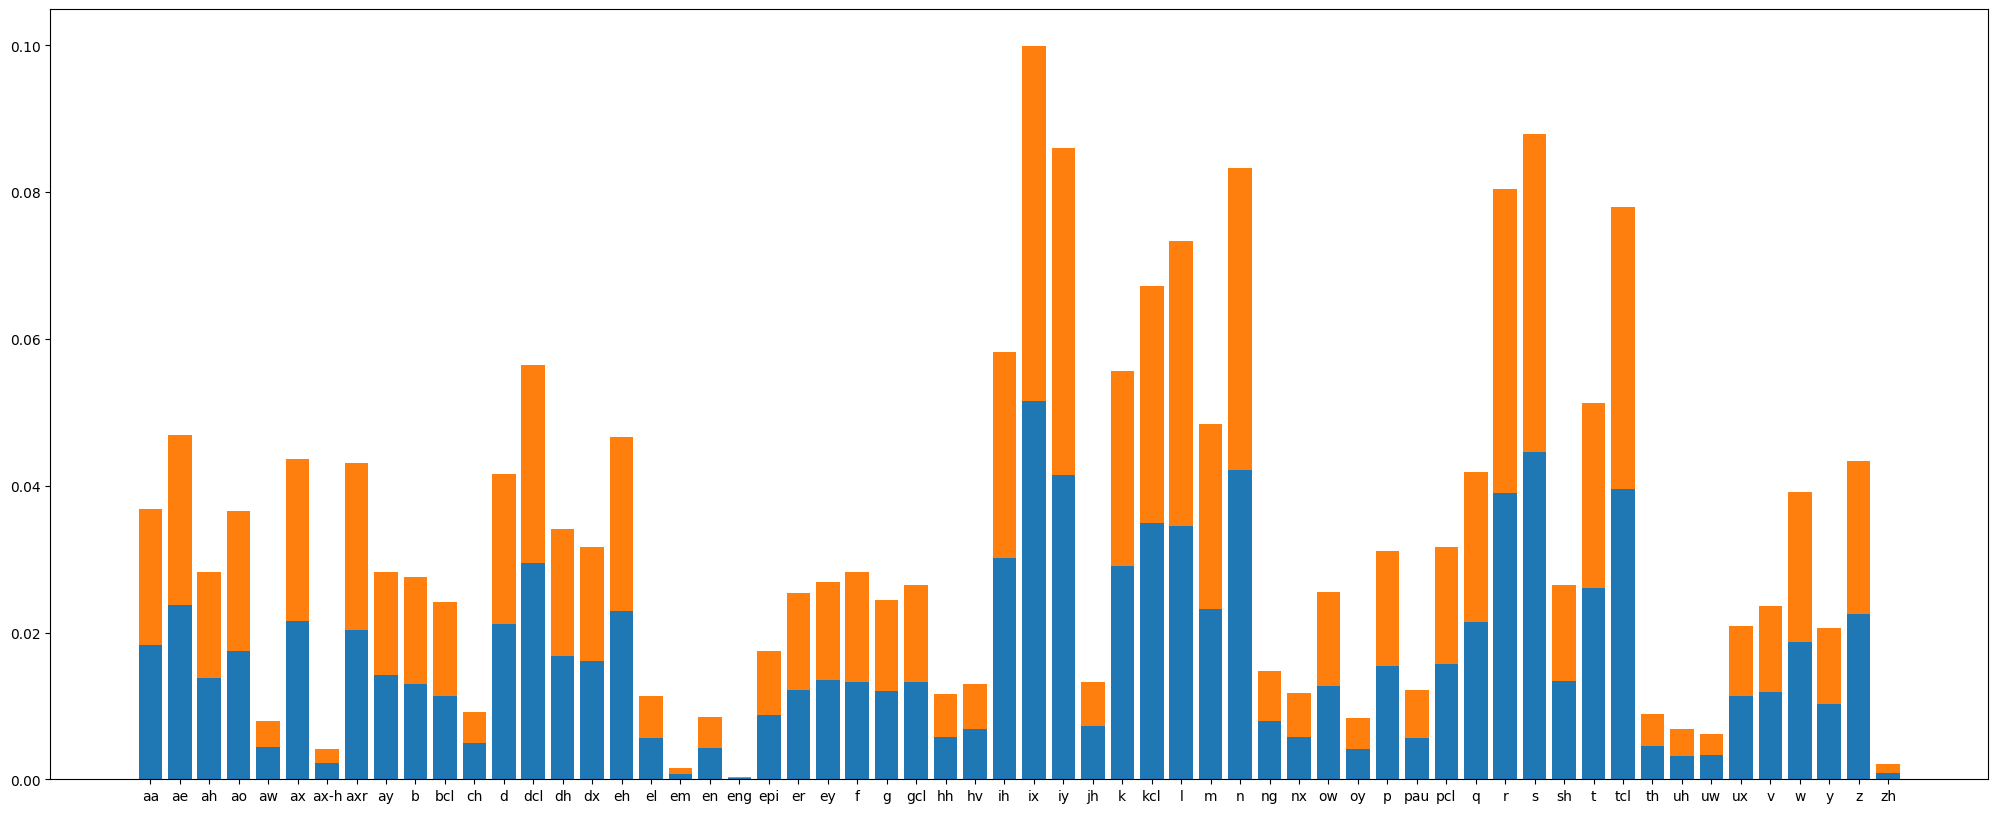

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(25,10))

# Plot train_phoneme counts
train_phoneme_counts = count_frequency(train_all_phonemes)
train_phoneme_ratio = [count / sum(train_phoneme_counts) for count in train_phoneme_counts]
plt.bar(phone_vocabs, train_phoneme_ratio)

# Plot test_phoneme counts
test_phoneme_counts  = count_frequency(test_all_phonemes)
test_phoneme_ratio  = [count / sum(test_phoneme_counts) for count in test_phoneme_counts]
plt.bar(phone_vocabs, test_phoneme_ratio, bottom=train_phoneme_ratio)

plt.show()

#### Show sample

In [10]:
import IPython.display as ipd
import numpy as np
import random

rand_int = random.randint(0, len(raw_datasets['train'])-1)

print("Text:", raw_datasets['train'][rand_int]["text"])
print("Utterances:", raw_datasets['train'][rand_int]["utterance"])
print("Phoneme Start Indices:", raw_datasets['train'][rand_int]["phoneme_start_idx"])
print("Input array shape:", raw_datasets['train'][rand_int]["audio"]["array"].shape)
print("Sampling rate:", raw_datasets['train'][rand_int]["audio"]["sampling_rate"])
ipd.Audio(data=raw_datasets['train'][rand_int]["audio"]["array"], autoplay=False, rate=16000)

Text: Most precincts had a third of the votes counted.
Utterances: ['h#', 'm', 'ah', 's', 'pcl', 'p', 'r', 'iy', 's', 'ih', 'ng', 'k', 's', 'hh', 'ae', 'dx', 'uh', 'th', 'er', 'dx', 'ax', 'dh', 'ax', 'v', 'ow', 'tcl', 't', 's', 'kcl', 'k', 'ae', 'l', 'ax', 'v', 'h#']
Phoneme Start Indices: [0, 2080, 2778, 4053, 5221, 6005, 6826, 7364, 8440, 10520, 12449, 13162, 13360, 15040, 15320, 16459, 16710, 17728, 19466, 21096, 21720, 22851, 23693, 24605, 25691, 27920, 28320, 28657, 29840, 30442, 31530, 32960, 34068, 35092, 35843]
Input array shape: (37479,)
Sampling rate: 16000


## Build Model Vocabulary
TODO: Probably don't need a vocab because we won't even be using a tokenizer?

# Modeling

## Instantiate utility objects

#### Create HF Dataset objects

In [11]:
from datasets import Dataset

BATCH_SIZE = 8

pick_features = ['audio', 'text', 'utterance', 'phoneme_start_idx', 'labels']
minimal_train_dataset = raw_datasets['train'].select(range(len(raw_datasets['train'])), pick_features)
minimal_test_dataset = raw_datasets['test'].select(range(len(raw_datasets['test'])), pick_features)

debug_train_dataset = minimal_train_dataset.shuffle(seed=42).select(range(1024))
debug_valid_dataset = minimal_test_dataset.shuffle(seed=42).select(range(128))

### Instantiate Tokenizer

In [12]:
# Calc unique phonemes
from dataset import PhonemeTokenizer

unique_phonemes = set(get_phoneme_list_from_dataset(minimal_train_dataset))
    
print(len(unique_phonemes))
    
# Create bidirectional dicts
phoneme_to_id = {}
id_to_phoneme = {}
for phoneme_id, phoneme in enumerate(unique_phonemes):
    phoneme_to_id[phoneme] = phoneme_id
    id_to_phoneme[phoneme_id] = phoneme
    
# Create tokenizer    
tokenizer = PhonemeTokenizer(phoneme_to_id, id_to_phoneme)

61


### Instantiate DataCollator

In [13]:
import torch
from dataset import DataCollatorForAudioWithPadding
from transformers import PreTrainedTokenizerFast

# The MockProcessor is a simplified stand-in for a more complex audio processor.
# It's used here to handle the padding of audio input features.
class MockProcessor:
    def pad(self, features, padding, return_tensors):
        # Find the maximum length of all input arrays
        max_len = max(len(f["input_values"]['array']) for f in features)
        
        # Pad each input array to the maximum length and stack them into a single tensor
        padded = torch.stack([
            torch.nn.functional.pad(
                torch.tensor(f["input_values"]['array']),
                (0, max_len - len(f["input_values"]['array']))
            ) 
            for f in features])
        
        # Return the padded tensor in the expected format
        return {"input_values": padded}

# Create an instance of the MockProcessor
processor = MockProcessor()

# Create a DataCollator using the MockProcessor and the previously defined tokenizer
collator = DataCollatorForAudioWithPadding(processor=processor, padding=True, tokenizer=tokenizer)

### Instantiate Model & Optimizer

In [14]:
from config import NUM_PHONEMES
from modeling import Wav2Vec2ForPhonemeAndFramePrediction
from transformers import AdamW, get_linear_schedule_with_warmup

model = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=NUM_PHONEMES, freeze_feature_encoder=True)
optimizer = AdamW(model.parameters(), lr=run_config['learning_rate'])
model.to(device);

Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/ubuntu/dev/jupyter/venv/lib/python3.10/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorc

## Prepare for training

#### Clear mem leaks

In [15]:
import gc
import torch

def clear_memory_leaks():
    # Assuming `obj` is the object consuming GPU memory
    obj = None
    gc.collect()
    torch.cuda.empty_cache()
    
clear_memory_leaks()

#### Define helpers

In [16]:
def generate_attention_mask(input_values):
    batch_size, sequence_length = input_values.shape
    attention_mask = torch.zeros((batch_size, sequence_length), dtype=torch.long, device=input_values.device)
    
    for i in range(batch_size):
        last_non_zero_idx = torch.nonzero(input_values[i], as_tuple=True)[0][-1].item()
        attention_mask[i, :last_non_zero_idx + 1] = 1
    
    return attention_mask

In [17]:
def shape_model_parameters(batch):
    inputs = batch['input_values'].to(device)
    labels = batch['labels']
    frame_labels = labels['phoneme_start_idx'].to(device)
    phoneme_labels = labels['utterance'].to(device)
    
    # Clever way to calculate the lengths of each audio vector (input) and each label (frame + phoneme)
    attention_mask = generate_attention_mask(batch['input_values']).to(device)
    input_lengths = attention_mask.sum(-1)
    label_lengths = (phoneme_labels != -100).sum(-1)

    # Move it all to the GPU
    inputs = inputs.to(device).to(torch.float32)
    phoneme_labels = phoneme_labels.to(device).to(torch.float32)
    frame_labels = frame_labels.to(device).to(torch.float32)

    # TODO: Create labels that are designed for BCE / CE loss and not CTC.
    phoneme_labels = phoneme_labels.to(device).to(torch.float32)
    frame_labels = frame_labels.to(device).to(torch.float32)

    return (input_lengths, inputs), (label_lengths, phoneme_labels, frame_labels)


def get_class_id_for_each_frame(frame_start_indices, classes, input_length_in_frames):
    batch_size = frame_start_indices.shape[0]
    
    # Create a mask for valid classes (not -100)
    valid_mask = classes != -100
    label_lengths = valid_mask.sum(dim=-1)
    
    # prep frame_start_indices ahead of 
    additional_column = torch.zeros((batch_size, 1), dtype=torch.float, device=valid_mask.device)
    frame_start_indices = torch.cat([frame_start_indices, additional_column], dim=1)

    # Calculate the number of frames for each class
    for i in range(batch_size):
        batch_input_length = input_length_in_frames[i]
        batch_label_length = label_lengths[i]
        frame_start_indices[i][batch_label_length] = batch_input_length


    frame_start_indices[:, 0] = 0
    frame_counts = torch.diff(frame_start_indices, dim=1)
    frame_counts = torch.where(valid_mask, frame_counts, torch.zeros_like(frame_counts))
    
    # Create a tensor to hold the result
    max_frames = input_length_in_frames.max().item()
    result = torch.full((batch_size, max_frames), -100, device=classes.device, dtype=classes.dtype)
    
    for i in range(batch_size):
        valid_classes = classes[i][valid_mask[i]]
        valid_counts = frame_counts[i][valid_mask[i]]
        
        # Valid_counts is wrong, the last value is incorrect
        expanded = torch.repeat_interleave(valid_classes, valid_counts.long())
        
        # Trim or pad to match input_length_in_frames
        if len(expanded) < input_length_in_frames[i]:
            padding = torch.full((input_length_in_frames[i] - len(expanded),), valid_classes[-1], device=classes.device, dtype=classes.dtype)
            expanded = torch.cat([expanded, padding])
        else:
            expanded = expanded[:input_length_in_frames[i]]
        
        # Fill the result tensor
        result[i, :len(expanded)] = expanded

    return result

## Start training loop

KeyboardInterrupt: 

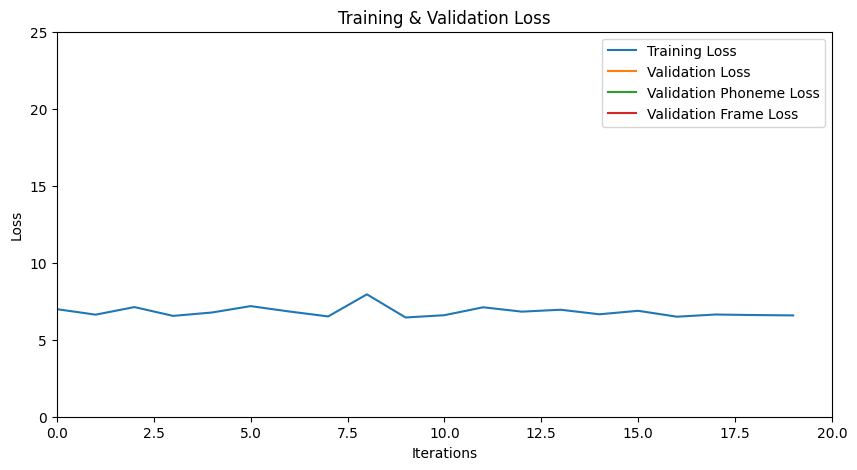

In [23]:
from pprint import pprint
from config import SAMPLE_RATE, WINDOW_SIZE
from modeling import custom_loss_function
from utils import create_bit_mask_of_frame_start_positions, frame_pos_to_nth_window, get_audio_length_in_windows_batched
from loss_and_evals import calculate_frame_metrics, calculate_phoneme_metrics

from torch.utils.data import DataLoader
from IPython.display import clear_output, display
import matplotlib.pyplot as plt

# Assume `train_dataset` is an instance of a custom Dataset class handling TIMIT data
num_epochs = 10
train_losses = []

train_loader = DataLoader(minimal_train_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True
valid_loader = DataLoader(minimal_test_dataset, batch_size=BATCH_SIZE, collate_fn=collator) #shuffle=True

steps_taken = 0

# Create chart
fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([], [], label='Training Loss')
val_line, = ax.plot([], [], label='Validation Loss')
val_phoneme_line, = ax.plot([], [], label='Validation Phoneme Loss')
val_frame_line, = ax.plot([], [], label='Validation Frame Loss')
ax.set_xlabel('Iterations')
ax.set_ylabel('Loss')
ax.set_title('Training & Validation Loss')
ax.legend()

validation_losses = []
validation_phoneme_losses = []
validation_frame_losses = []
validation_iterations = []

train_metrics = {
    "frame_precision": [],
    "frame_recall": [],
    "frame_f1": [],
    "phoneme_precision": [],
    "phoneme_recall": [],
    "phoneme_f1": [],
}
# Use 0s to init the validation until we actually do inference on the validation set before doing any training
valid_metrics = {
    "frame_precision": [0],
    "frame_recall": [0],
    "frame_f1": [0],
    "phoneme_precision": [0],
    "phoneme_recall": [0],
    "phoneme_f1": [0],
}

def update_metrics(prefix, new_metrics, dict):
    for metric_name, metric_value in new_metrics.items():
        dict[f"{prefix}_{metric_name}"].append(metric_value.item())

def print_metrics(metrics, dataset_type="[_____]"):
    print(f"{dataset_type} Metrics:")
    print(f"Phoneme P:  {metrics['phoneme_precision'][-1]:.4f}, Frame P:  {metrics['frame_precision'][-1]:.4f}")
    print(f"Phoneme R:  {metrics['phoneme_recall'][-1]:.4f}, Frame R:  {metrics['frame_recall'][-1]:.4f}")
    print(f"Phoneme F1: {metrics['phoneme_f1'][-1]:.4f}, Frame F1: {metrics['frame_f1'][-1]:.4f}")

for epoch in range(num_epochs):
    train_loss = 0.0  # Add this line to initialize the training loss accumulator
    val_loss = 0.0
    val_phoneme_loss = 0.0
    val_frame_loss = 0.0
    for batch in train_loader:    
        model.train()
        
        (input_lengths, inputs), (label_lengths, phoneme_labels, frame_labels) = shape_model_parameters(batch)
        
        # Convert the input tensor to the same data type as the model parameters
        inputs = inputs.to(dtype=next(model.parameters()).dtype)

        phoneme_pred_logits, frame_start_pred = model(inputs, phoneme_labels=phoneme_labels)  # Forward pass

        num_windows_in_ea_sample = torch.floor_divide(torch.div(input_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

        frame_positions = frame_pos_to_nth_window(frame_labels)
            
        frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_pred_logits.shape[1]).to(device)

        loss, phoneme_loss, frame_loss = custom_loss_function(
            phoneme_pred_logits,
            frame_start_pred, 
            phoneme_labels, 
            frame_bitmask_labels,
            num_windows_in_ea_sample,
            label_lengths,
            device=device
        )
        
        train_loss += loss.item()  # Add this line to accumulate the training loss
        train_losses.append(loss.item())
        
        optimizer.zero_grad()  # Reset gradients to zero
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        steps_taken += 1
        
        ## Plot train losses
        line.set_data(range(len(train_losses)), train_losses)
        ax.set_xlim(0, len(train_losses))
        ax.set_ylim(0, 25) #max(train_losses)
        
        clear_output(wait=True)
        display(fig)

        # # Import necessary functions from loss_and_evals.py
        input_length_in_frames = get_audio_length_in_windows_batched(batch['input_values']).to(device)
        phoneme_actual_labels = get_class_id_for_each_frame(frame_positions, phoneme_labels, input_length_in_frames)

        phoneme_metrics = calculate_phoneme_metrics(phoneme_pred_logits, phoneme_actual_labels)
        frame_metrics = calculate_frame_metrics(frame_start_pred, frame_bitmask_labels)

        update_metrics("phoneme", phoneme_metrics, dict=train_metrics)
        update_metrics("frame", frame_metrics, dict=train_metrics)
        
        if steps_taken % 64 == 0:
            model.eval()
            print('Running validation set against model...')
            val_loss = 0.0
            val_phoneme_loss = 0.0
            val_frame_loss = 0.0

            metrics = {
                "frame_precision": 0,
                "frame_recall": 0,
                "frame_f1": 0,
                "phoneme_precision": 0,
                "phoneme_recall": 0,
                "phoneme_f1": 0,
            }
            with torch.no_grad():
                for val_batch in valid_loader:
                    (input_lengths, inputs), (label_lengths, phoneme_labels, frame_labels) = shape_model_parameters(val_batch)

                    # Inference and Loss Computation
                    phoneme_pred_logits, frame_start_pred = model(inputs, phoneme_labels=phoneme_labels)

                    # Assuming `custom_loss_function` is defined and `frame_bitmask_labels` and `num_windows_in_ea_sample` are computed
                    frame_positions = frame_pos_to_nth_window(frame_labels)
                    frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_pred_logits.shape[1]).to(device)
                    num_windows_in_ea_sample = torch.floor_divide(torch.div(input_lengths*1000, SAMPLE_RATE) - 5, WINDOW_SIZE).long()

                    batch_val_loss, batch_phoneme_loss, batch_frame_loss = custom_loss_function(
                        phoneme_pred_logits,
                        frame_start_pred, 
                        phoneme_labels, 
                        frame_bitmask_labels,
                        num_windows_in_ea_sample,
                        label_lengths,
                        device=device
                    )
                    
                    val_loss += batch_val_loss.item()
                    val_phoneme_loss += batch_phoneme_loss.item()
                    val_frame_loss += batch_frame_loss.item()

                    # # Import necessary functions from loss_and_evals.py
                    input_length_in_frames = get_audio_length_in_windows_batched(inputs).to(device)
                    phoneme_actual_labels = get_class_id_for_each_frame(frame_positions, phoneme_labels, input_length_in_frames)

                    phoneme_metrics = calculate_phoneme_metrics(phoneme_pred_logits, phoneme_actual_labels)
                    frame_metrics = calculate_frame_metrics(frame_start_pred, frame_bitmask_labels)

                    phoneme_precision = phoneme_metrics["precision"]
                    phoneme_recall = phoneme_metrics["recall"]
                    phoneme_f1 = phoneme_metrics["f1"]
                    
                    frame_precision = frame_metrics["precision"]
                    frame_recall = frame_metrics["recall"]
                    frame_f1 = frame_metrics["f1"]

                    metrics["frame_precision"] += frame_precision
                    metrics["frame_recall"] += frame_recall
                    metrics["frame_f1"] += frame_f1
                    metrics["phoneme_precision"] += phoneme_precision
                    metrics["phoneme_recall"] += phoneme_recall
                    metrics["phoneme_f1"] += phoneme_f1

            val_loss /= len(valid_loader)
            val_phoneme_loss /= len(valid_loader)
            val_frame_loss /= len(valid_loader)
            # val_frame_loss *= 20 # Adjust according to loss fn

            validation_losses.append(val_loss)
            validation_phoneme_losses.append(val_phoneme_loss)
            validation_frame_losses.append(val_frame_loss)

            validation_iterations.append(steps_taken)

            # Plot validation losses
            val_line.set_data(validation_iterations, validation_losses)
            val_phoneme_line.set_data(validation_iterations, validation_phoneme_losses)
            val_frame_line.set_data(validation_iterations, validation_frame_losses)

            # Normalize metrics results based on num batches
            for k in metrics.keys():
                metrics[k] /= len(valid_loader)
                valid_metrics[k].append(metrics[k])


        print_metrics(train_metrics, dataset_type="Train")
        print_metrics(valid_metrics, dataset_type="Test")

        # Log metrics
        wandb.log({
            "val_loss": val_loss,
            "val_phoneme_loss": val_phoneme_loss,
            "val_frame_loss": val_frame_loss,
            # Train
            "train_phoneme_precision": train_metrics["phoneme_precision"],
            "train_phoneme_recall": train_metrics["phoneme_recall"],
            "train_phoneme_f1": train_metrics["phoneme_f1"],
            "train_frame_precision": train_metrics["frame_precision"],
            "train_frame_recall": train_metrics["frame_recall"],
            "train_frame_f1": train_metrics["frame_f1"],
            # Test
            "test_phoneme_precision": valid_metrics["phoneme_precision"],
            "test_phoneme_recall": valid_metrics["phoneme_recall"],
            "test_phoneme_f1": valid_metrics["phoneme_f1"],
            "test_frame_precision": valid_metrics["frame_precision"],
            "test_frame_recall": valid_metrics["frame_recall"],
            "test_frame_f1": valid_metrics["frame_f1"]
        }, step=steps_taken)
    

    train_loss /= len(train_loader)  # Add this line to calculate the average training loss

    
    print(f"Epoch {epoch}, Training loss: {train_loss}")  # Add this line to print the average training loss
    print(f"Epoch {epoch}, Validation loss: {val_loss}")
    
plt.close(fig)

# Measure training performance

In [ ]:
num_phonemes = 61
model_untrained = Wav2Vec2ForPhonemeAndFramePrediction(num_phonemes=61, freeze_feature_encoder=True)
model_untrained.to(device);

batch = next(iter(valid_loader))
idx = 4
batch = {
    'input_values': batch['input_values'],#[idx].unsqueeze(0), 
    'labels': { 
        'phoneme_start_idx': batch['labels']['phoneme_start_idx'],#[idx].unsqueeze(0), 
        'utterance': batch['labels']['utterance'],#[idx].unsqueeze(0) 
    }
}


Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.masked_spec_embed']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of MyWav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized because the shapes did not match:
- lm_head.bias: found shape torch.Size([32]) in the checkpoint and torch.Size([62]) in the model instantiated
- lm_head.weight: found shape torch.Size([32, 768]) in the checkpoint and torch.Size([62, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Run inference on trained + untrained model

In [ ]:
from importlib import reload
import config
reload(config)
import utils
reload(utils)

from utils import frame_pos_to_nth_window, create_bit_mask_of_frame_start_positions


#### EXTRACT COMMON DATA FROM BATCH
(input_lengths, inputs), (label_lengths, phoneme_labels, frame_labels) = shape_model_parameters(batch)

#### CREATE GROUND TRUTH FRAME MARKERS
frame_positions = frame_pos_to_nth_window(frame_labels)
frame_bitmask_labels = create_bit_mask_of_frame_start_positions(frame_positions, phoneme_pred_logits.shape[1]).to(device)
print(f"Frame markers - actual: ", frame_labels[0].shape)

num_windows_in_ea_sample = torch.floor_divide(torch.div(input_lengths*1000, config.SAMPLE_RATE) - 5, config.WINDOW_SIZE).long()

#### [INFERENCE] TRAINED MODEL
phoneme_pred_logits, frame_start_pred = model(inputs, phoneme_labels=phoneme_labels)
print(f"Frame markers - trained: ", frame_start_pred.shape)

loss, phoneme_loss, frame_start_loss = custom_loss_function(
    phoneme_pred_logits, # FROM MODEL
    frame_start_pred, # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    label_lengths, # FROM BATCH
    device=device 
)

#### [INFERENCE] UNTRAINED MODEL
phoneme_pred_logits_UN, frame_start_pred_UN = model_untrained(inputs, phoneme_labels=phoneme_labels)
print(f"Frame markers - untrained: ", frame_start_pred_UN.shape)

loss_UN, phoneme_loss_UN, frame_start_loss_UN = custom_loss_function(
    phoneme_pred_logits_UN, # FROM MODEL
    frame_start_pred_UN,  # FROM MODEL
    # -------
    phoneme_labels, # FROM BATCH
    frame_bitmask_labels, # FROM BATCH
    num_windows_in_ea_sample, # FROM BATCH
    label_lengths, # FROM BATCH
    device=device
)


#### [LOGGING]
print(f"Epoch {epoch}, TRAINED  | Frame Start Validation loss: {frame_start_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Frame Start Validation loss: {frame_start_loss_UN.item()}")
print(f"Epoch {epoch}, TRAINED  | Phoneme loss: {phoneme_loss.item()}")
print(f"Epoch {epoch}, UNTRAINED| Phoneme loss: {phoneme_loss_UN.item()}")

Frame markers - actual:  torch.Size([60])
Shape: torch.Size([8, 248, 768])
Shape: torch.Size([8, 248, 768])
Frame markers - trained:  torch.Size([8, 248])
Shape: torch.Size([8, 248, 768])
Shape: torch.Size([8, 248, 768])
Frame markers - untrained:  torch.Size([8, 248])
Epoch 9, TRAINED  | Frame Start Validation loss: 0.05726180970668793
Epoch 9, UNTRAINED| Frame Start Validation loss: 0.5432118773460388
Epoch 9, TRAINED  | Phoneme loss: 0.3649977743625641
Epoch 9, UNTRAINED| Phoneme loss: 16.322864532470703


## Actual vs. predicted Frame Marker positions

In [ ]:
from plots import visualize_bitmask
from utils import get_audio_length_in_windows

# visualize_bitmask(frame_bitmask_labels.squeeze(0), frame_start_pred.squeeze(0), frame_start_pred_UN.squeeze(0))
# visualize_bitmask(frame_bitmask_labels.squeeze(0), frame_start_pred.squeeze(0), frame_start_pred.squeeze(0) > 0.6)
# sample_idx = batch['labels']['phoneme_start_idx'][0]
# frame_pos_to_nth_window(sample_idx)
get_audio_length_in_windows(batch['input_values'][0])
len(batch['input_values'][0]) / SAMPLE_RATE

import IPython.display as ipd
ipd.Audio(batch['input_values'][0].cpu().numpy(), rate=SAMPLE_RATE)

## Spectrogram + Framestart marker overlay

In [ ]:
from utils import get_audio_length_in_windows

print(frame_pos_to_nth_window(batch['input_values'].shape[1]))
print(get_audio_length_in_windows(batch['input_values'][0]))



tensor(248, dtype=torch.int32)
248


(1025, 156)
(513, 311)
(1025, 156)
(513, 311)


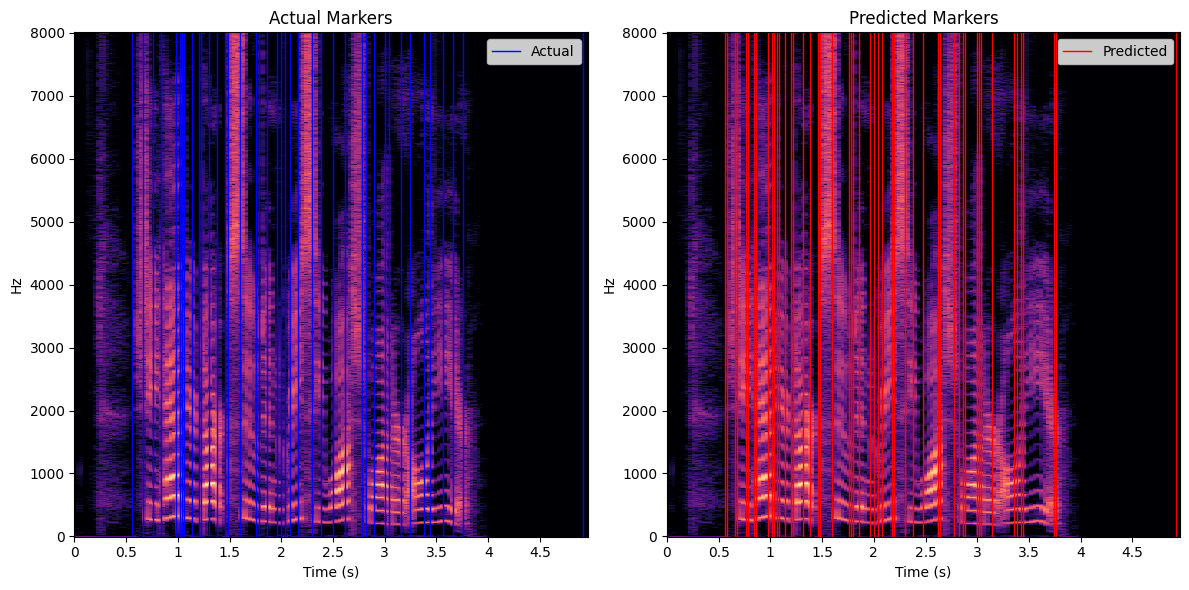

In [ ]:
from plots import visualize_audio_and_markers
from utils import get_audio_length_in_windows

inputs, label = batch['input_values'], batch['labels']

sample_index = 0 
sample = inputs[sample_index]
# The window indices
start_window = 0  
end_window = len(frame_start_pred[0]) 

# Get bitmask / start markers
sample_start_idx = label['phoneme_start_idx']
window_start_idx_actual = frame_pos_to_nth_window(sample_start_idx)
num_of_windows = get_audio_length_in_windows(sample)
start_idx_bitmask_actual = create_bit_ask_of_frame_start_positions(
    window_start_idx_actual,
    num_of_windows
).to(device)

import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

visualize_audio_and_markers(
    sample,
    start_window,
    end_window,
    start_idx_bitmask_actual[sample_index],
    label_type='Actual',
    color='blue',
    ax=ax1
)
ax1.set_title('Actual Markers')


visualize_audio_and_markers(
    sample,
    start_window,
    end_window,
    frame_start_pred[sample_index] > 0.25,
    label_type='Predicted',
    color='red',
    ax=ax2
)
ax2.set_title('Predicted Markers')

plt.tight_layout()
plt.show()

# [sample for sample in frame_start_pred[sample_index] if sample < 0 or sample > 1]

ValueError: could not broadcast input array from shape (8,248) into shape (8,)

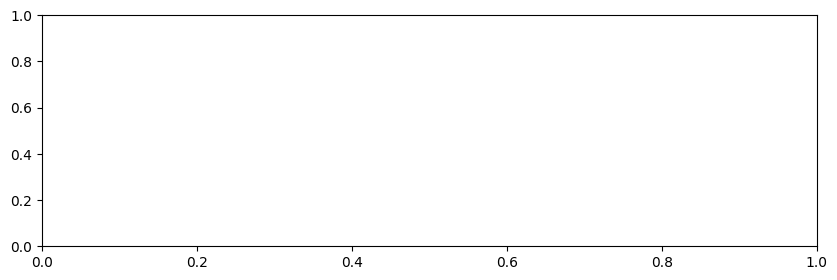

In [ ]:
# visualize_bitmask(frame_bitmask_labels.squeeze(0), frame_start_pred.squeeze(0), frame_start_pred_UN.squeeze(0))
visualize_bitmask(frame_bitmask_labels.squeeze(0), frame_start_pred.squeeze(0) > 0.33, frame_start_pred.squeeze(0), model1_label="> 0.33 prob predictions")

In [ ]:
from utils import save_model

save_model(model, "badbeagle_model")

Model saved as: models/20241012_170941_badbeagle_model.pth


max_values_pred torch.Size([8, 248])
labels_actual torch.Size([8, 248])


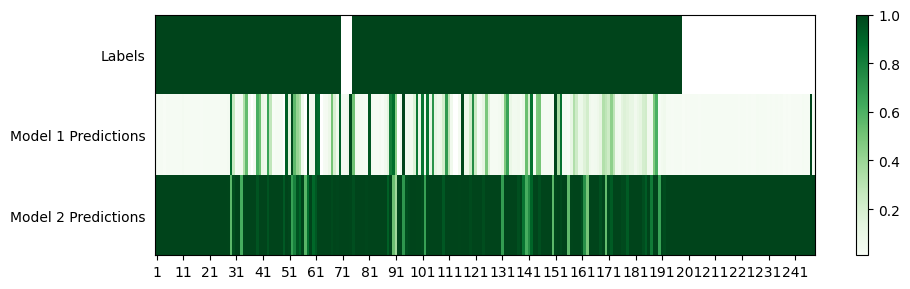

----- PHONEME ----
{'f1': tensor(0.1709), 'precision': tensor(0.1709), 'recall': tensor(0.1709)}

----- FRAME ------
{'f1': tensor(0.7518), 'precision': tensor(0.8619), 'recall': tensor(0.6667)}



In [ ]:
from pprint import pprint
from utils import get_audio_length_in_windows_batched
from loss_and_evals import calculate_frame_metrics, calculate_phoneme_metrics
from torch import nn

input_length_in_frames = get_audio_length_in_windows_batched(batch['input_values']).to(device)
labels_actual = get_class_id_for_each_frame(frame_positions, phoneme_labels, input_length_in_frames)

# Invoke top_k_accuracy_plot
phoneme_probs = nn.functional.softmax(phoneme_pred_logits, dim=-1)

# PLOT
max_indices = torch.argmax(phoneme_probs, dim=-1).unsqueeze(-1) # Creates e.g. [8, MAX_FRAME_LEN, 1] vectors
max_values_pred = torch.gather(phoneme_probs, -1, max_indices).squeeze(-1)

print('max_values_pred', max_values_pred.shape)
print('labels_actual', labels_actual.shape)

visualize_bitmask(labels_actual[0], frame_start_pred[0], max_values_pred[0])



input_length_in_frames = get_audio_length_in_windows_batched(batch['input_values']).to(device)
labels_actual = get_class_id_for_each_frame(frame_positions, phoneme_labels, input_length_in_frames)

print("----- PHONEME ----")
pprint(calculate_phoneme_metrics(phoneme_pred_logits.detach().cpu(), labels_actual.detach().cpu()))
print("")
print("----- FRAME ------")
pprint(calculate_frame_metrics(frame_start_pred.detach().cpu(), frame_bitmask_labels.detach().cpu()))
print("")


frame_start_indices.shape >>>  torch.Size([8, 72])
frame_start_indices >>>  tensor([[  0.,   8.,   9.,  15.,  20.,  25.,  28.,  30.,  32.,  35.,  40.,  45.,
          48.,  53.,  59.,  63.,  71.,  74.,  77.,  84.,  89.,  91.,  94., 101.,
         103., 104., 110., 113., 114., 119., 120., 126., 127., 128., 130., 139.,
         146., 148., 151., 160., 167.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,   0.],
        [  0.,   6.,   8.,  13.,  16.,  17.,  18.,  24.,  28.,  32.,  36.,  37.,
          43.,  46.,  47.,  54.,  62.,  68.,  74.,  75.,  79.,  80.,  82.,  85.,
          86.,  91.,  94.,  96.,  99., 104., 107., 107., 110., 114., 116., 122.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,  -1.,
          -1.,  -1.,  -1.,  -1.,

[tensor(38.), tensor(38.), tensor(38.), tensor(38.), tensor(38.), tensor(38.), tensor(38.), tensor(38.), tensor(9.), tensor(39.), tensor(39.), tensor(39.), tensor(39.), tensor(39.), tensor(39.), tensor(42.), tensor(42.), tensor(42.), tensor(42.), tensor(42.), tensor(59.), tensor(59.), tensor(59.), tensor(59.), tensor(59.), tensor(12.), tensor(12.), tensor(12.), tensor(15.), tensor(15.), tensor(3.), tensor(3.), tensor(12.), tensor(12.), tensor(12.), tensor(14.), tensor(14.), tensor(14.), tensor(14.), tensor(14.), tensor(22.), tensor(22.), tensor(22.), tensor(22.), tensor(22.), tensor(2.), tensor(2.), tensor(2.), tensor(43.), tensor(43.), tensor(43.), tensor(43.), tensor(43.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(18.), tensor(18.), tensor(18.), tensor(18.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(46.), tensor(6.), tensor(6.), tensor(6.), tensor(8.), tensor(8.), tensor(8.), tensor(14.

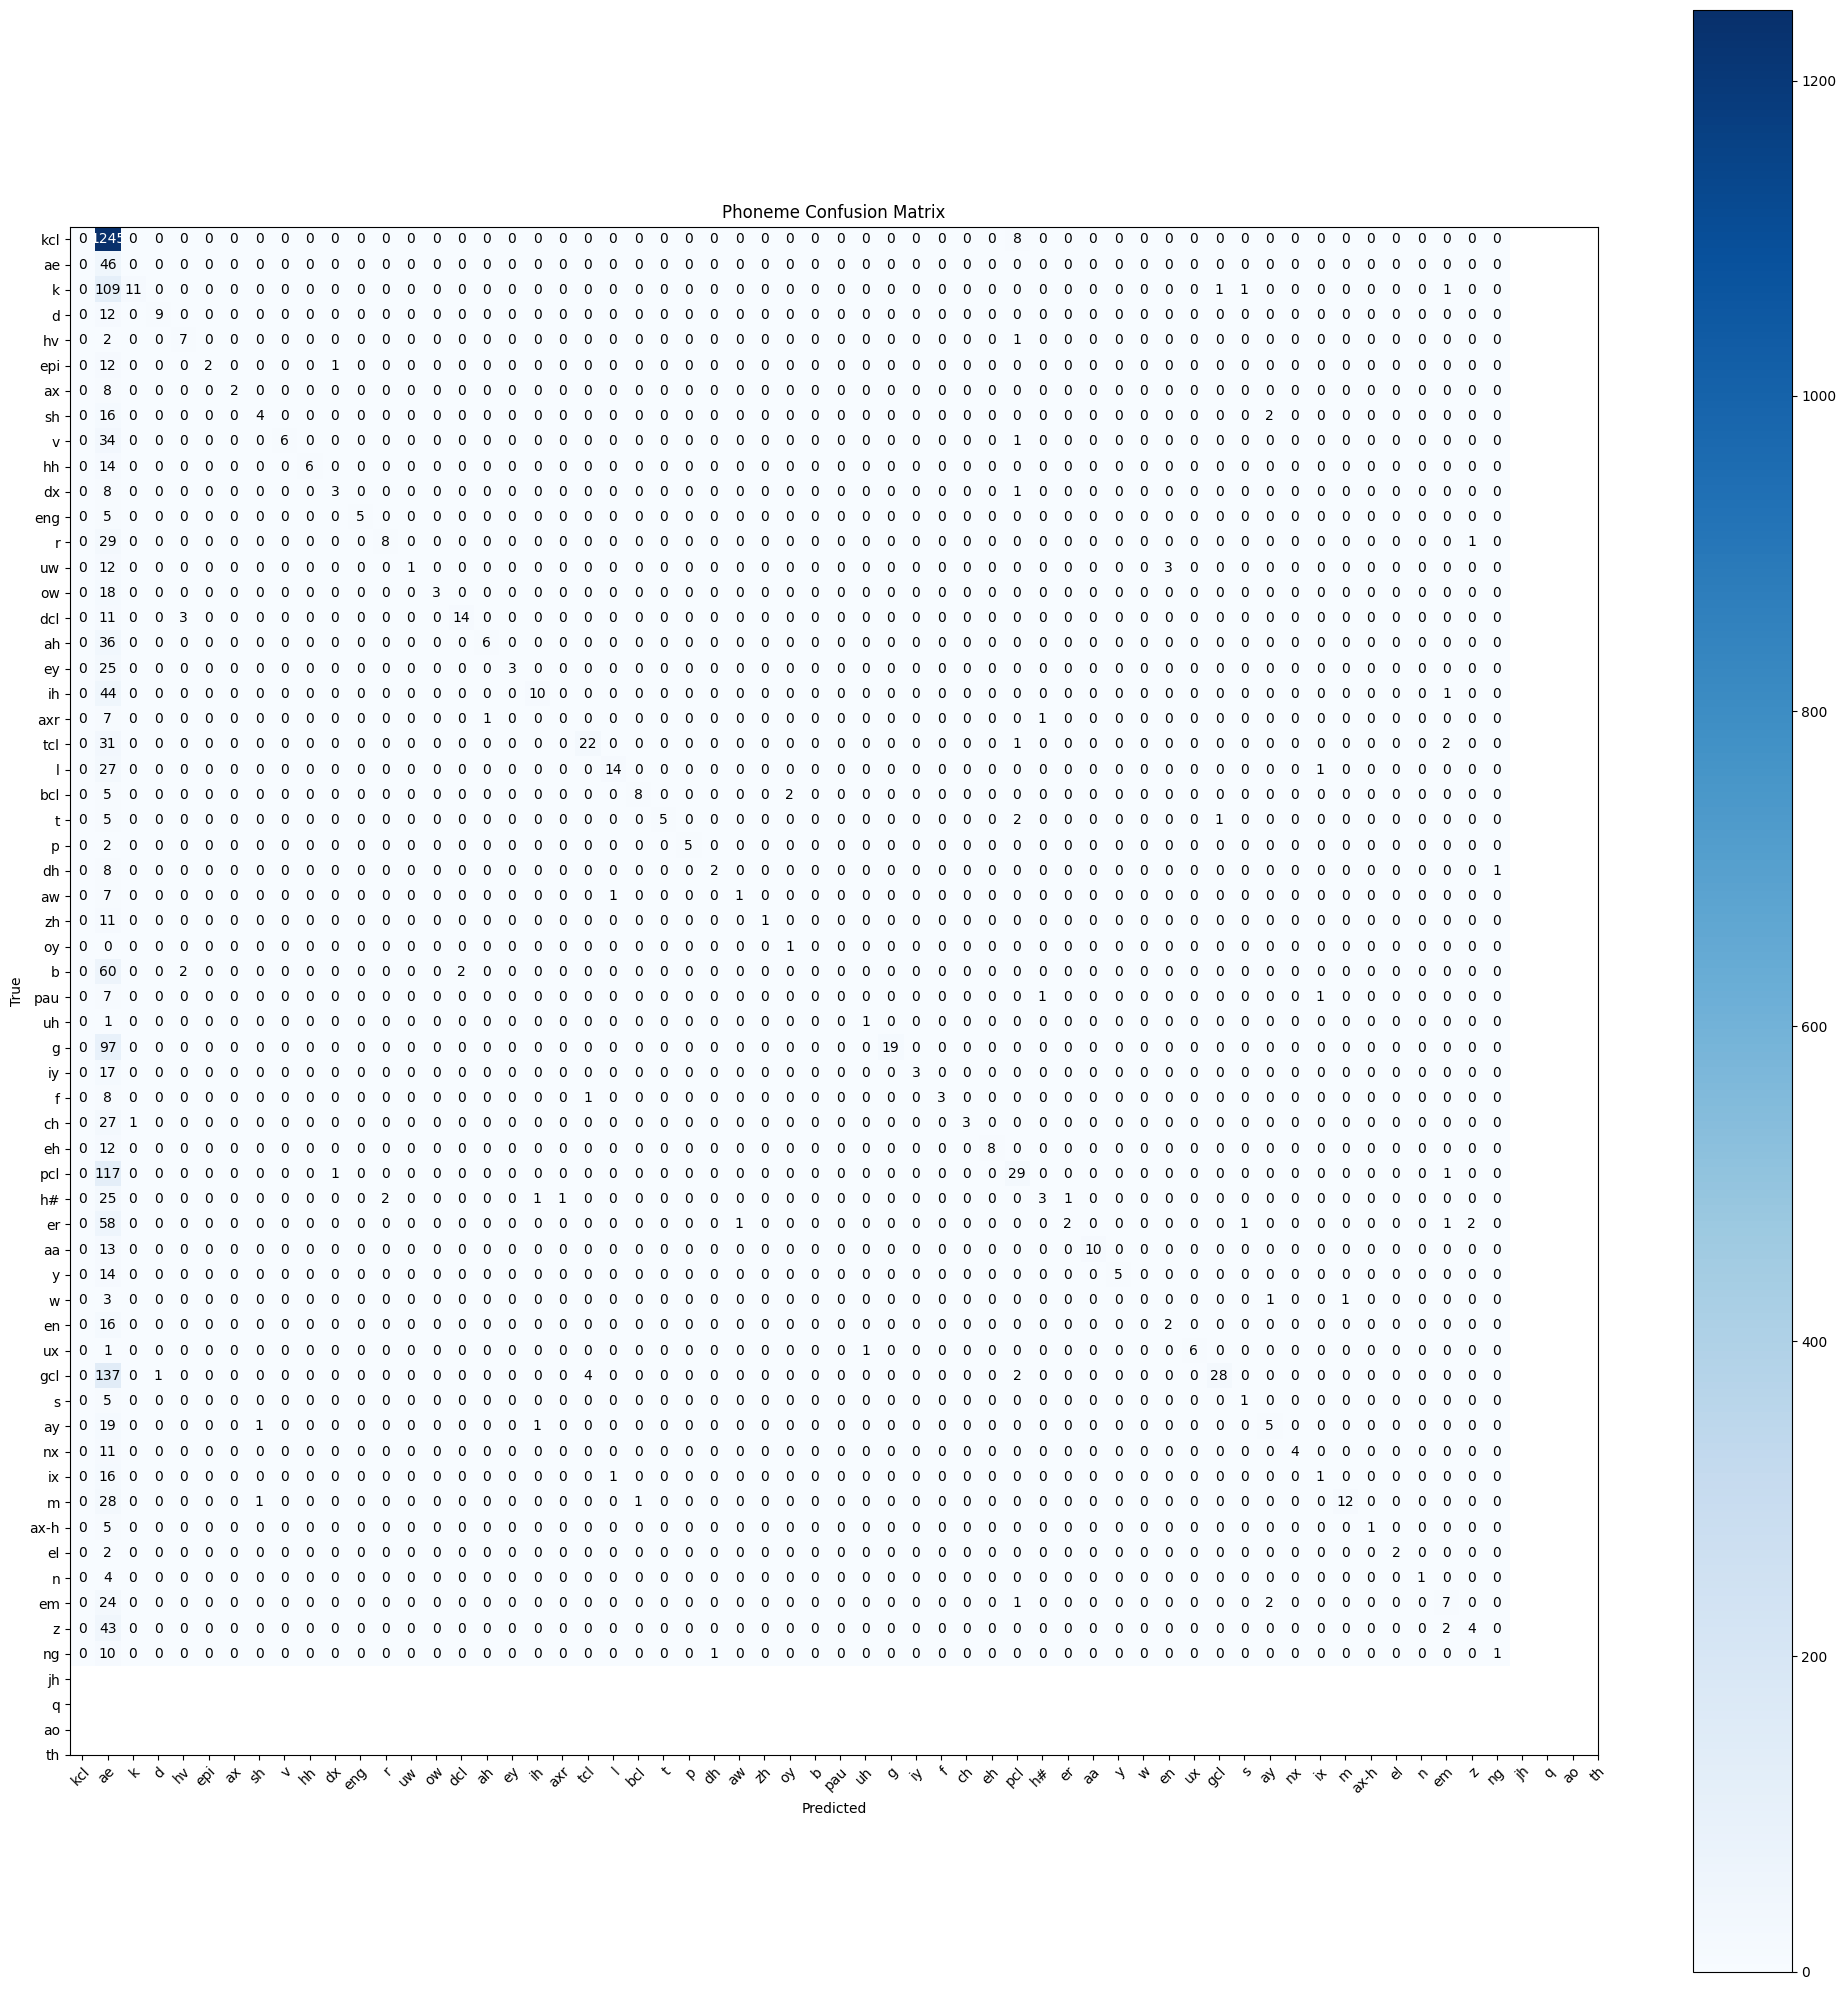

In [ ]:
from sklearn.metrics import confusion_matrix
import numpy as np

def plot_confusion_matrix(model, data_loader, ax, title, id_to_phoneme=id_to_phoneme):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        xxx = 0
        for val_batch in valid_loader:
            if (xxx == 1):
                (input_lengths, inputs), (label_lengths, phoneme_labels, frame_labels) = shape_model_parameters(val_batch)
                input_length_in_frames = get_audio_length_in_windows_batched(inputs).to(device)
                frame_positions = frame_pos_to_nth_window(frame_labels)
                labels_actual = get_class_id_for_each_frame(frame_positions, phoneme_labels, input_length_in_frames)

                # Inference and Loss Computation
                phoneme_pred_logits, frame_start_pred = model(inputs, phoneme_labels=phoneme_labels)
                phoneme_pred_probs = torch.softmax(phoneme_pred_logits, dim=-1)
                phoneme_pred_classes = torch.argmax(phoneme_pred_probs, dim=-1)

                all_preds.extend(phoneme_pred_classes.flatten().detach().cpu())
                all_labels.extend(labels_actual.flatten().detach().cpu())
            xxx += 1
    
    print(all_labels)
    print(all_preds)
    cm = confusion_matrix(all_labels, all_preds)
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    ax.figure.colorbar(im, ax=ax)
    
    # Get class names
    class_names = list(id_to_phoneme.values())
    
    # Ensure that the number of ticks matches the number of class names
    tick_marks = np.arange(len(class_names))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(class_names, rotation=45, ha="right", rotation_mode="anchor")
    ax.set_yticklabels(class_names)
    
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_title(title)

    # Loop over data dimensions and create text annotations
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], 'd'),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    
    plt.tight_layout()

fig, (ax1) = plt.subplots(1, 1, figsize=(20, 20))

cuda_model = model.to(device)
plot_confusion_matrix(cuda_model, valid_loader, ax1, 'Phoneme Confusion Matrix')
plt.show()